# __Welcome to the MMS Engineering Challenge!__

This notebook provides you some code to setup a MMS Data Engineering problem. There is no optimal solution, but many good answers. We only want to see if you know how to tackle the problem. There is a lot of room for your approach to the problem.

Goal: We want you to predict the number of __sales_per_day__ (= label) with the given dataset and put it into production.


Short explanation of the dataset:
- __outlet_id__: The ID of a outlet/market
- __country__: The country in which the outlet is located
- __brand__: "MediaMarkt" or "Saturn"
- __customers_per_day__: The number of customers per day in this outlet
- __sales_per_day__: The amount of sales for a specific outlet on a specific day
- __currency__: The currency of __sales_per_day__
- __week_id__: Calendar week
- __weekday__: mon = Monday, tue = Tuesday, ... , sun = Sunday

In [1]:
import pandas as pd
import numpy as np

data_path = 'data.csv' # maybe you have to modify this...
data = pd.read_csv(data_path, sep=';')
print(data.head())

        brand  country currency  customers_per_day  outlet_id  week_id  \
0  MediaMarkt    spain     EURO             3138.0      100.0     34.0   
1      Saturn  germany     EURO              378.0       86.0      8.0   
2  MediaMarkt    italy     EURO              379.0      530.0     28.0   
3      Saturn  germany     EURO             3050.0       17.0     47.0   
4  MediaMarkt    spain     EURO              548.0      164.0      7.0   

  weekday  sales_per_day  
0     sat       72169.14  
1     mon       52825.62  
2     thu       53309.83  
3     sat       74237.45  
4     tue       56621.61  


# Challenge
Now it is your turn. Show us how you are tackeling this problem. You have complete freedom what you do.

## Exploration
The goal here is to better understand the underlying data e.g. in terms of completeness, distribution etc..

In [2]:
import plotly.express as px
import matplotlib.pyplot as plt

In [3]:
data.describe()

customers_per_day      outlet_id        week_id  sales_per_day
count       18199.000000   18194.000000   18194.000000   18193.000000
mean          259.351503    -301.265747    -852.575684   50823.378059
std         26758.789881   24590.138649   29643.403749   31283.133925
min       -999999.000000 -999999.000000 -999999.000000 -999999.000000
25%           327.000000      97.000000      14.000000   51260.450000
50%           550.000000     255.000000      27.000000   57319.920000
75%          1605.000000     530.000000      40.000000   63163.580000
max          4734.000000     698.000000      52.000000   96225.530000

The data is a time series as it can be interpreted as an evolution in time. However, we can not assume the data is bounded to one natural year or otherwise it is maybe March to March. Which means we can not assume a chronological order from week 1 to week 52. Moreover, there is one outlet which has more days than a natural year.

In [4]:
outlet_size_s = data.groupby('outlet_id').size()
print(f"Outlets with more days than a year (outlet_id: #days): {outlet_size_s[outlet_size_s > 365].to_dict()}")

Outlets with more days than a year (outlet_id: #days): {598.0: 714}


### Drop erroneous and null data

In the previous dataframe description it can be observed that there are odd values for all numerical data: `-999999`. This is even the case for `outlet_id` and `week_id`, which in fact are not numerical but categorical. This might be due to erroneous data. In fact, as it can be observed in the following description, this is the only negative number provided in these columns. For this reason, these values will be dropped. They will be considered as missing data.

Another strategy instead of removing both erroneous and nulls would be to fill these gaps. There are multiple strategies for such situations. A common option would be to replace it with the mean value of each column, this tends to have a less biasing effect on the predictor during the training proces.

In [5]:
cond_neg = (data.loc[:, data.describe().columns] == -999999).any(axis=1)
data.loc[~cond_neg, :].describe()

customers_per_day     outlet_id      week_id  sales_per_day
count       18151.000000  18146.000000  18146.00000   18145.000000
mean          974.416781    303.501819     26.85793   51283.976045
std           888.222455    216.140206     14.72468   22208.149055
min             0.000000     14.000000      1.00000       0.000000
25%           327.000000     97.000000     14.00000   51269.000000
50%           551.000000    255.000000     27.00000   57325.620000
75%          1606.000000    530.000000     40.00000   63160.540000
max          4734.000000    698.000000     52.00000   96225.530000

In [6]:
cond_neg = (data.loc[:, data.describe().columns] < 0).any(axis=1)
data.drop(data.index[cond_neg], inplace=True)

Now the NaNs will be treated.

In [7]:
total_nulls = data.isna().any(axis=1).sum()
print(f"There is a total of {total_nulls} rows with null values " +\
      f"out of {len(data)} ({round(total_nulls/len(data), 4)*100}%)")
data.isna().sum()

There is a total of 162 rows with null values out of 18159 (0.89%)


brand                33
country              22
currency             23
customers_per_day     8
outlet_id            13
week_id              13
weekday              37
sales_per_day        14
dtype: int64

The null registers will also be dropped. Note that, as it was mentioned, we could also use different strategies such as inferring the missing data (using variable's mean value for instance).

In [8]:
data.dropna(inplace=True)

In [9]:
data = data.astype({'customers_per_day': int, 'outlet_id': int, 'week_id': int})

### The distribution of the target variale
We can observe that there is a great number of 0s in the target variable. This might be a problem and have a bad impact on the predictor's performance. On the other hand, we can observe that this is due to the sundays when no sales are done. For having a more balanced data we will drop the sundays.

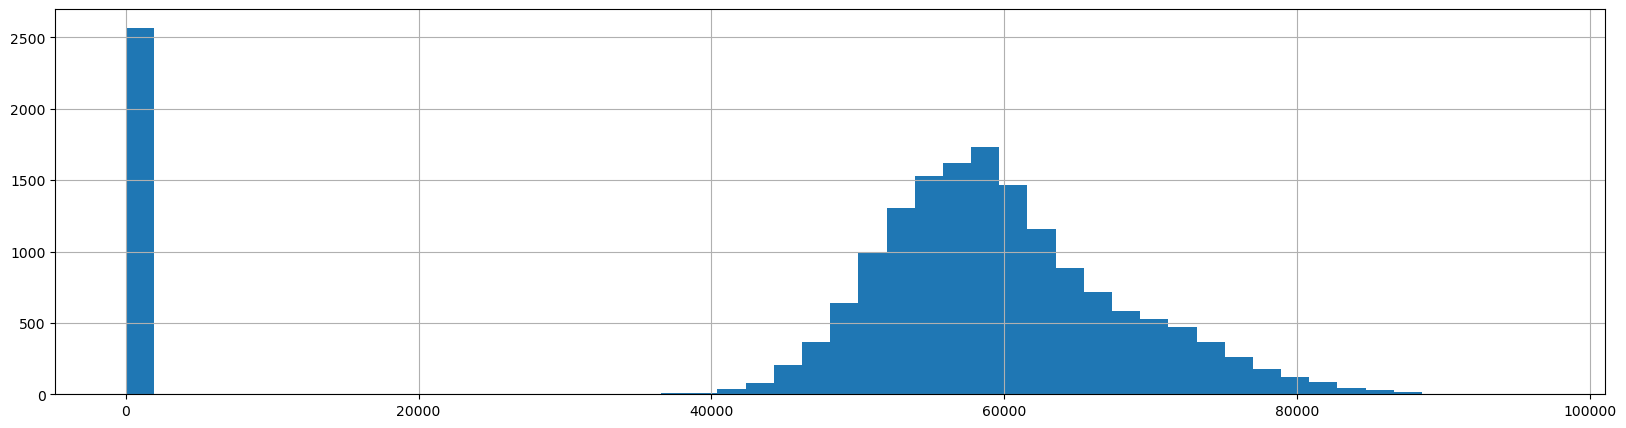

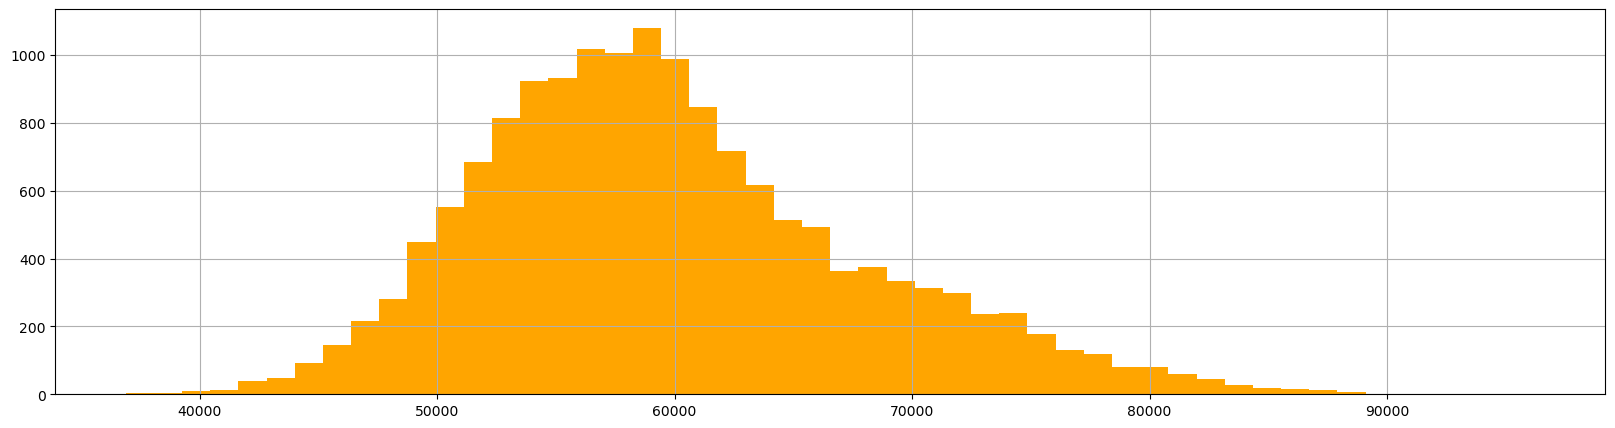

count          mean          std       min         25%        50%  \
weekday                                                                       
fri      2565.0  58880.203548  5312.093940  39665.02  55381.8900  58720.020   
mon      2574.0  54408.746826  4660.675583  37432.63  51312.2300  54391.125   
sat      2570.0  72169.182837  5650.015228  53008.84  68299.6025  71910.260   
sun      2569.0      0.000000     0.000000      0.00      0.0000      0.000   
thu      2568.0  58627.144945  4475.593059  43234.68  55600.2100  58519.345   
tue      2576.0  52805.616506  4682.345900  36881.67  49695.3475  52761.995   
wed      2575.0  62031.109344  4992.147313  45469.43  58726.2300  61855.630   

                75%       max  
weekday                        
fri      62162.9000  80386.35  
mon      57628.7100  71122.41  
sat      75643.8000  96225.53  
sun          0.0000      0.00  
thu      61494.9725  72106.72  
tue      55927.1175  67932.14  
wed      65271.5400  79236.69

In [10]:
data.loc[:, 'sales_per_day'].hist(bins=50, figsize=(20, 5))
plt.show()
# data.loc[data.loc[:, 'sales_per_day'] > 0, 'sales_per_day'].hist(bins=50, figsize=(20, 5), color='orange')
# plt.show()
data.loc[data.loc[:, 'weekday'] != 'sun', 'sales_per_day'].hist(bins=50, figsize=(20, 5), color='orange')
plt.show()
data.groupby('weekday')['sales_per_day'].describe()

In [11]:
cond = data.loc[:, 'weekday'] == 'sun'
data.drop(data.index[cond], inplace=True)

### Variable relations: categorical
Here we can observe the distribution of the different categorical data and one could point out some particularities. Such as:
- Saturdays are the top seller days.
- There are slight differences in sales per country, being Switzerland the top seller.
- The weekly tendency throughout the year has a notable change during the last weeks.

In [12]:
num_c = ['customers_per_day']
target = 'sales_per_day'
cat_c = set(data.columns) - set(num_c+[target])

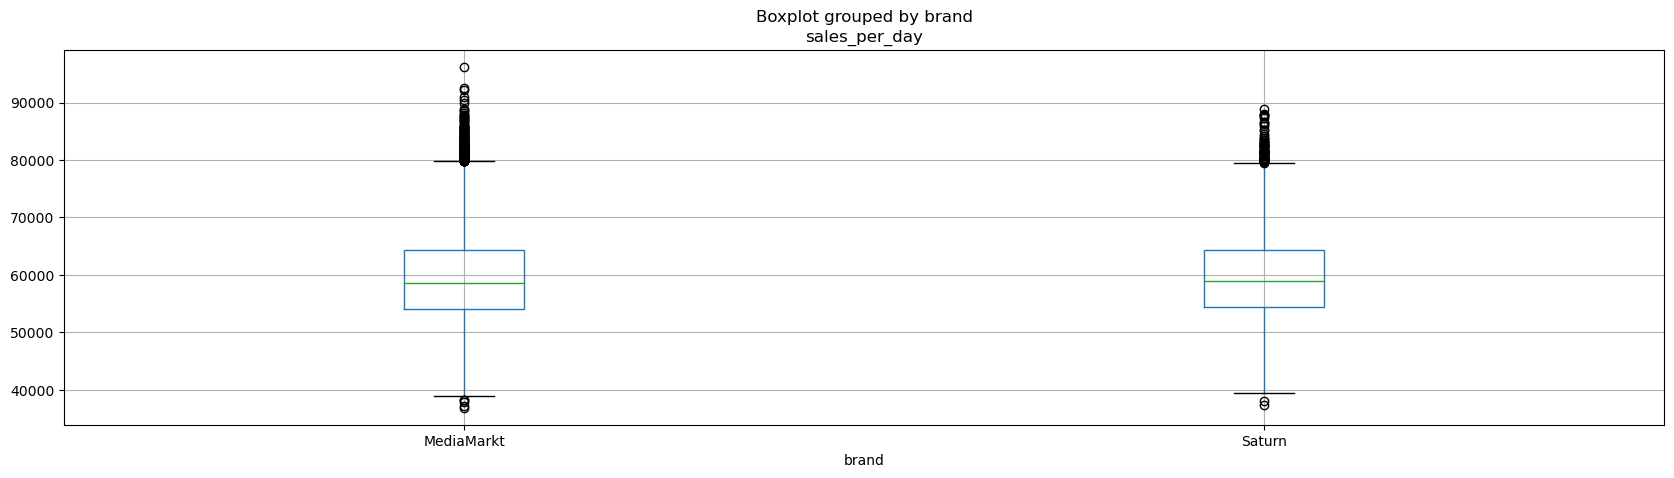

              count          mean       min       max
brand                                                
MediaMarkt  10892.0  59776.895916  36881.67  96225.53
Saturn       4536.0  59914.587500  37432.63  88954.39


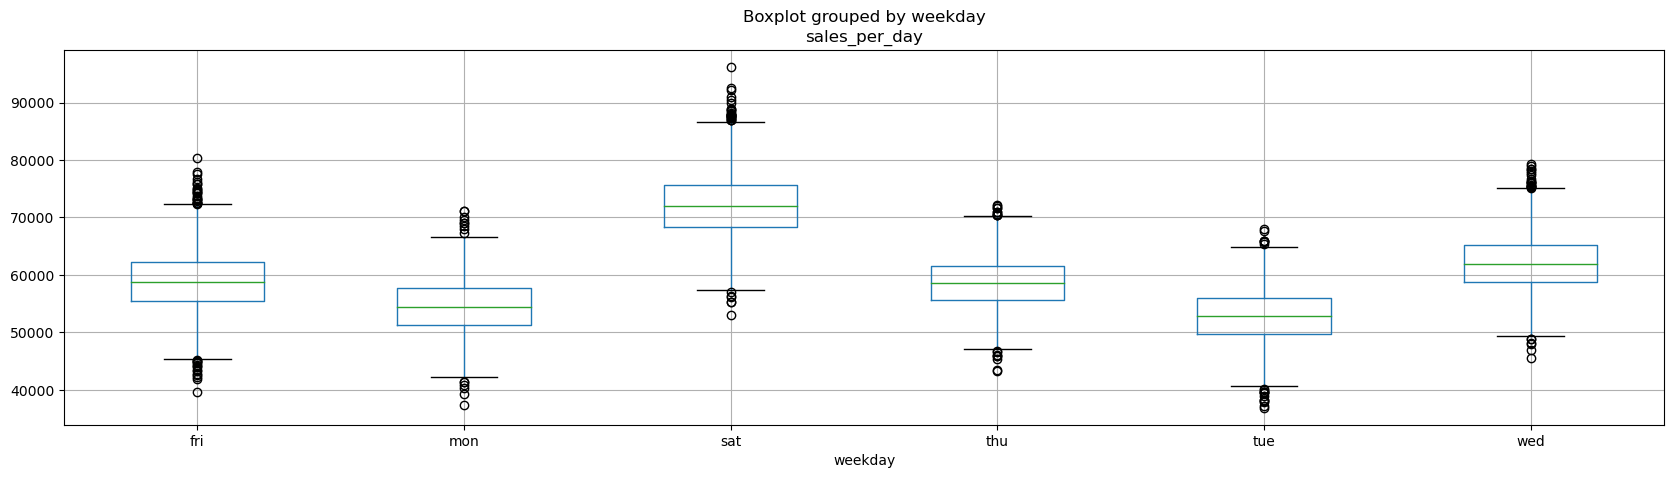

          count          mean       min       max
weekday                                          
fri      2565.0  58880.203548  39665.02  80386.35
mon      2574.0  54408.746826  37432.63  71122.41
sat      2570.0  72169.182837  53008.84  96225.53
thu      2568.0  58627.144945  43234.68  72106.72
tue      2576.0  52805.616506  36881.67  67932.14
wed      2575.0  62031.109344  45469.43  79236.69


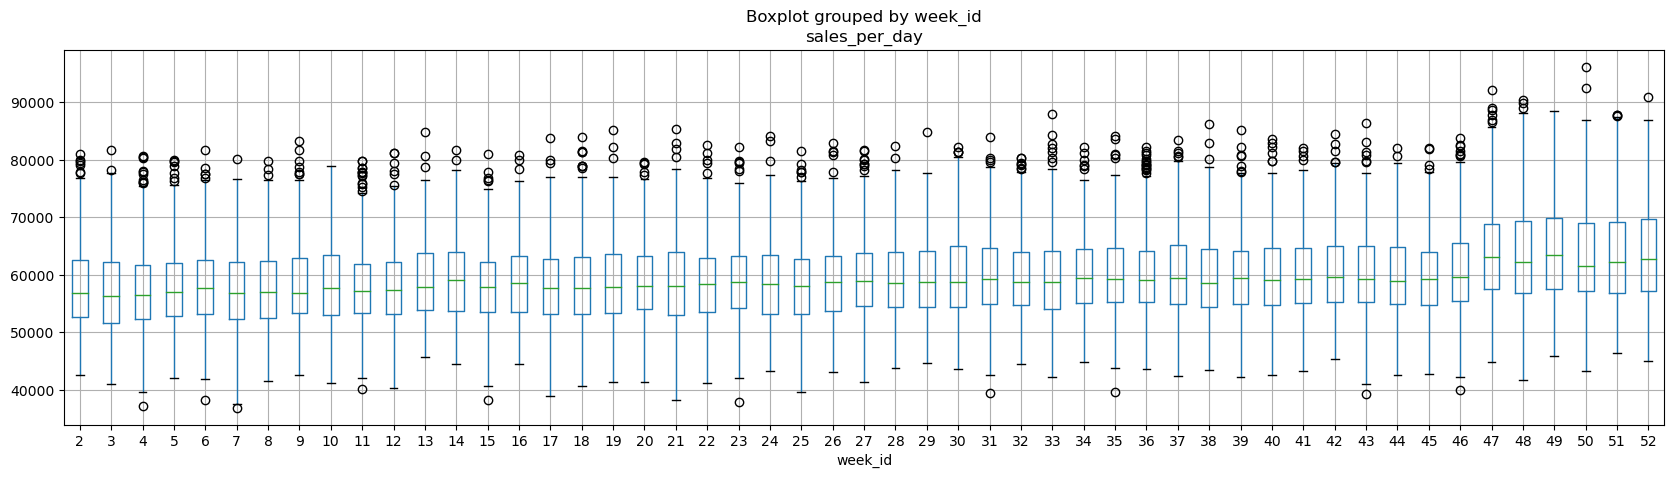

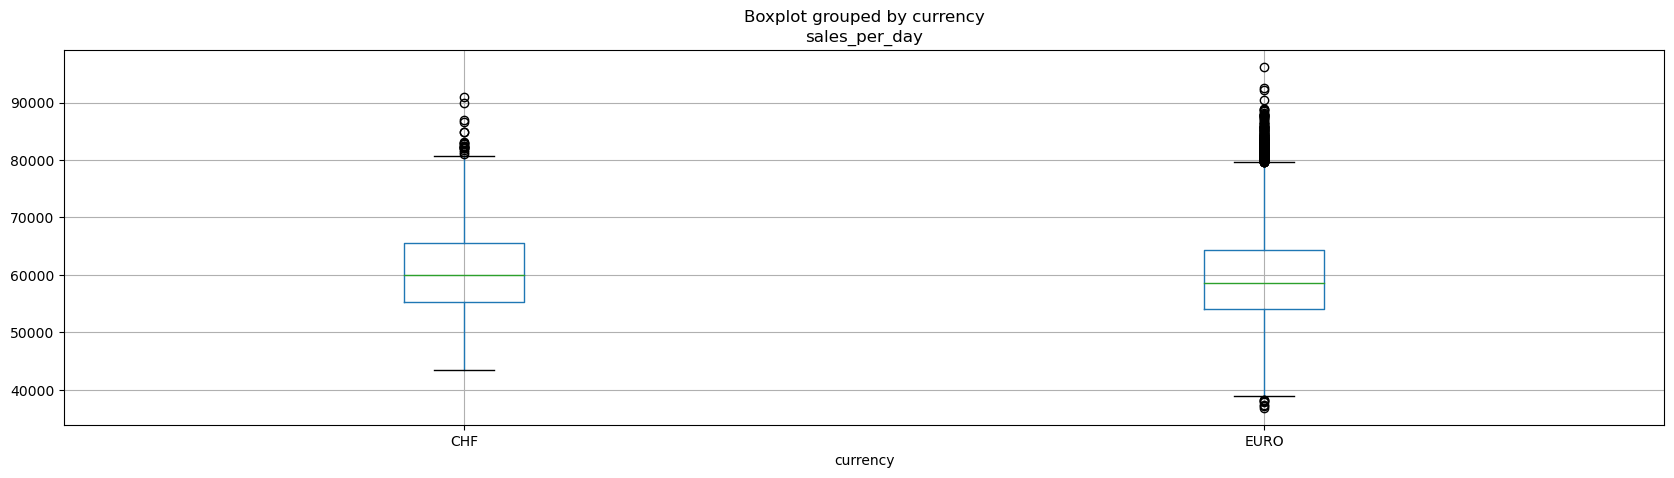

            count          mean       min       max
currency                                           
CHF         910.0  61138.188945  43526.14  90952.05
EURO      14518.0  59734.589288  36881.67  96225.53


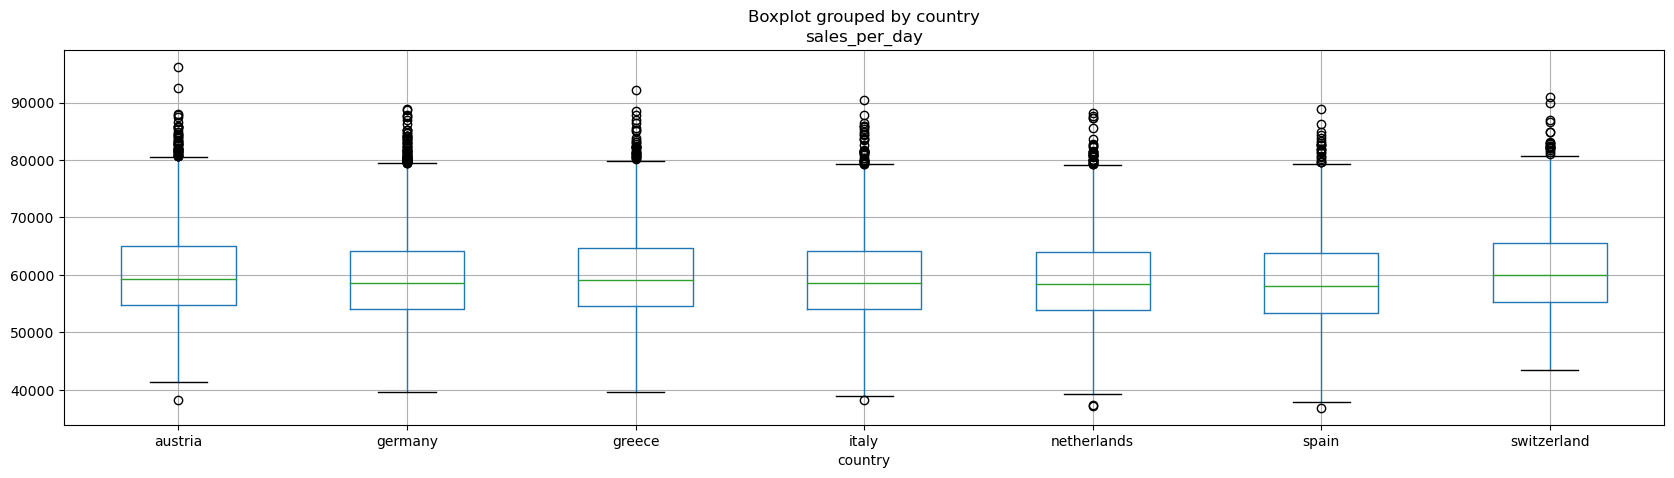

              count          mean       min       max
country                                              
austria      2113.0  60594.637454  38207.95  96225.53
germany      4240.0  59630.330858  39665.02  88945.31
greece       1813.0  60126.447330  39578.53  92180.92
italy        2418.0  59613.841960  38256.83  90479.53
netherlands  1817.0  59557.651046  37173.73  88204.00
spain        2117.0  59039.170846  36881.67  88954.39
switzerland   910.0  61138.188945  43526.14  90952.05


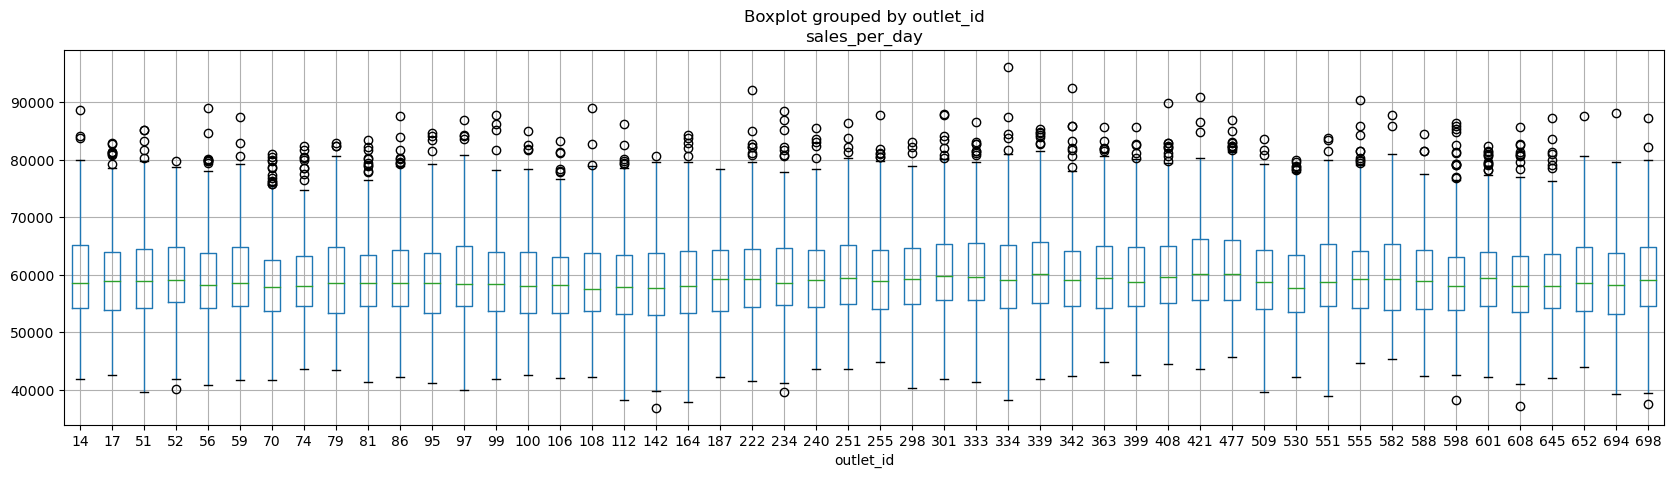

In [13]:
for c in cat_c:
    data.boxplot(column=target, by=c, figsize=(20, 5))
    plt.show()
    if c in ('outlet_id', 'week_id'):
        continue
    print(data.groupby(c)[target].describe().loc[:, ['count', 'mean', 'min', 'max']])

### Numerical varialbes: distribution and correlations

I am also adding here the `week_id` although it could be considered as a categorical variable. The reason is because I am defining the hypothesis that the seasonality has a great impact on the sales.

In the following plots we can observe that there is a clear linear relation between `sales_per_day` and `customers_per_day`. Regarding the relation with `week_id`, we can observe on the one hand what appears to be linearity with `sales_per_day`. This might be strongly impacted by the end of year (mainly black friday + christmas) sales. On the other hand we can also observe that there is a scaling of the customers in the last period of the year, which again provides this elevated number of sales.

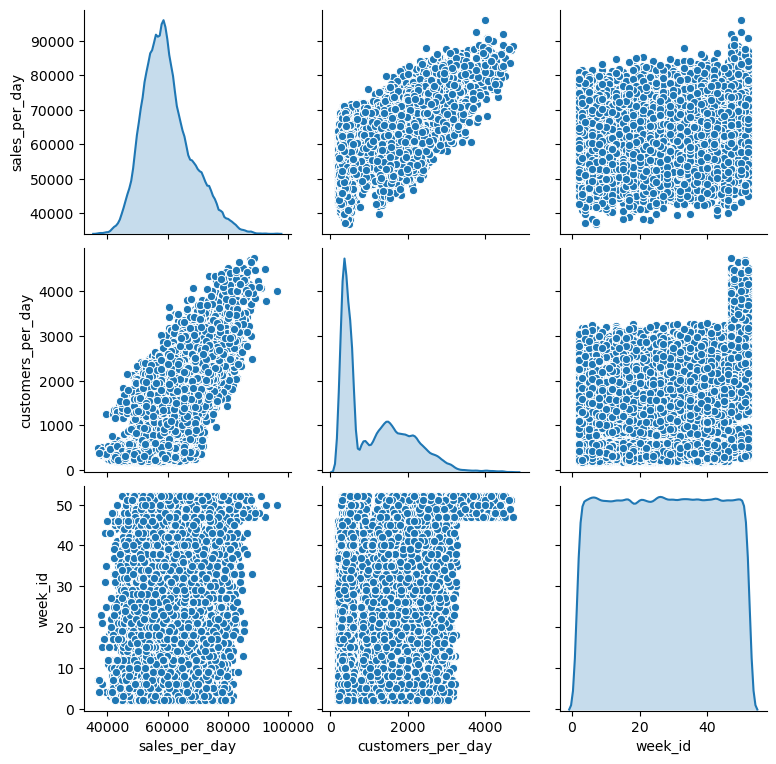

In [14]:
import seaborn as sns

corr_c = ['sales_per_day', 'customers_per_day', 'week_id']
sns.pairplot(data.sample(1000000, replace=True).loc[:, corr_c], diag_kind='kde')
plt.show()

## Modelling
Choose a suitable model for predicting the sales_per_day and validating the prediction accuracy. Train and test the model.
##### Exp DS
* Can we have a base model or a benchmark ?

> Yes we can compare the values obtained with dummy models or very simple models. Being the simplest model providing the global average of `sales_per_day` for every register (`glob_avg`). Another option would be using a day of week average value (`dow`). Note that we will use these two dummy models for benchmarking and the intention is to keep them simple, however it could be possible to use models like KNN-1 for this purpose.

* While choosing a suitable model, kindly specify in 1-2 lines why you choose this specific model, asumptions, and disadvantage of using this model.

> The KNN model provides the best results for the model. The different models tested are KNN, SVM and the elastic net (which is a combination of a Lasso and a Ridge models). In this case after trying different configurations for each of the models, the best performance has been obtained for the KNN model with K=20. This model will use the K Nearest Neighbours in the training dataset for estimating the value of each prediction.
> One of the main disadvantages for this model is that it is not capable to detect temporal patterns on time series. This is also the case for the other models tested on this exercise. For solving this problem I think it would be an excellent choice to test Recurrent Neural Networks (RNNs), especially LSTM. These models have _memory_ within temporal data and can be used to capture patterns. However, training processes for NNs could become slightly more tedious (although not much more: https://www.tensorflow.org/tutorials/structured_data/time_series) and the disk usage of these models (when stored) tends to be higher (although the disk usage of KNN is not ideal as well). But the main stopper for training an LSTM model on the current problem is the lack of chonologicality. As it was previously mentioned since there is no information of the year, we cannot assume that the Tuesday on week_id 2 is later (chronologically) than the Wednesday on week_id 37. The first one could be from year 2019 and the latter form year 2018.
> Another important drawback in using `knn` is the misinterpretation in categorical variables' relation. For instance, in the country code. Categorical variables have coded as numbers: beeing 1-germany, 2-greece and 3-italy. The KNN algorithm is based on computing euclidean distances for finding the nearest neighbours. Hence, we should note that germany (1) and greece (2) might not make sense to be nearer than germany (1) and italy (3).

* What would be the suitable metric to evaluate the model ? Again, kindly specify why you choose this metric ?

> A good option could be the RMSE, which can actually be easily interpreted given the data. In this case, we would be considering the averge error in the prediction which can be interpreted directly with repect to the distribution of sales per day. In other words, the value of rmse can be directly interpreted as the impact on the sales per day value difference with respect to the real data.

* Most important, with your choosen model and it's metric how would you explain a non-techie product owner why should we use your solution ?

> Firstly, it would be very important to properly inform the product owner about the metric used. For this reason, it could be interesting to set a more suitable name such as "average error in sales". The name could be decided together with the PO so that he/she gets more familiarized. Once settled, it would be a matter of computing this metric for all models under-study.
> However, sometimes one should decide to choose slightly poorer solutions (in terms of metrics) because another aspect outperforms the first option. This could be a matter of simplicity, for instance, linear models are very easily stored in DB (and almost weightless). This could be a very good reason for wanting to use them. Given this situation it would be of paramount importance to provide the PO the essential information so that there can be an agreement.

##### Sr. DS
* How would you keep track of model performance over time (assuming you get latest data daily) and how would you maintian it's performance.

> We could have the chosen metric evaluated daily / weekly and build a score. This process would give us a notion of how "well" is the model performing. It would also be a good practise to set a lower bound in performance or a minimum acceptable score for the performance. Once this lower bound is reached an automatic retraining of the model could be issued using the latest data. Moreover, I would suggest regularly retraining the model so that it is up to date.

* The sample data used in this excercise scales to various countries, how would you ensure that your solution is scalable to other countries ?

> In the current model, the country is coded as a number, so if a new country appears this would be one of the variables used in computing the _nearest neighbours_. However, even though this variable will not make much sense the rest will still be suitable for the prediction process.
> However, some variables do not make much sense to be compared using euclidian distances. An example of this is the country, where country 0 and 1, don't need to be more similar than 0 and 2. An improvement of this could be generating different models for each of the countries and when a new country appears, choose the model with the most similar market. Or coding these similarities in the country code itself, and for instance range them in terms of size or market.

* If this was supose to be the actual problem/requirement from your Product Owner (PO), how would you negotiate the requirements/manage expectations with the PO ?

> I would try to be very clear with the model performance since it is a great indicator of what to expect. In this case our model outperforms the base models. But since the real data has a regular pattern, one could say that `knn` only slightly outperforms `dow`. This sentence is indeed true, and for this reason I would suggest investing more time in this project (maybe try LSTM).
> However, even though the performance is just _slightly_ better in terms of corr and rmse, we can also observe that `knn`is much better when the data regularity is broken, as we can see in the tendency change at the end of the year.

### 1. Coding categorical variables as numbers

In [15]:
xData = data.copy()
for c in cat_c:
    vals = sorted(xData.loc[:, c].unique())
    mapper = dict(zip(vals, list(range(len(vals)))))
    xData.loc[:, c] = xData.loc[:, c].map(mapper)

### 2. Splitting train and test datasets
Then the data is split into train and test data sets. This splitting proces is done randomly with a prop of 80% train and 20% test. Note that this splitting process can be done randomly because of the models tested. The models trained (knn, elastic, svm) do not capture temporal patterns and for this reason a random split is suitable. However, as it has already been mentioned a good model for this problem would probably be a Recurrent Neural Network which is capable of detecting temporal patterns and tendencies. With RNNs the splitting proces has to be handled differently, since we are interested in mantaining the chronological coherence in both datasets.

In [16]:
def split_data(xDF, yS, perc=0.8):
    randomIdx = np.random.choice(range(xDF.shape[0]), size=int(xDF.shape[0]*perc), replace=False)
    trainCond = xDF.index.isin(randomIdx)
    xTrain, xTest, yTrain, yTest = xDF.iloc[trainCond, :], xDF.iloc[~trainCond, :], \
                                   yS.iloc[trainCond], yS.iloc[~trainCond]
    return xTrain, xTest, yTrain, yTest

features = num_c+list(cat_c)
# features = ['customers_per_day', 'weekday', 'week_id', 'outlet_id', 'country']
xTrain, xTest, yTrain, yTest = split_data(xData.loc[:, features], data.loc[:, target])

### 3. Scaling the data

In [17]:
# scale data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler(with_mean=True, with_std=True)
scaler = MinMaxScaler()
xTrainScaled = scaler.fit_transform(xTrain)
xTestScaled = scaler.transform(xTest)

### 4. Configuring the models to train and its parameters tested in Cross Validation

Note that the SVM model is commented out. It has been also tested, however its GridSearch cross validation in the following section is very time-consuming compared to the others. And the results are not better than the ones from elastic.

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from metrics_lib import *

model_cands = {
    'elastic': {'estimator': ElasticNet(fit_intercept=True, max_iter=5000, random_state=np.random.RandomState(1234)),
                'params': {'alpha': 10 ** np.linspace(5, -2, 50), 'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.75, 0.95, 1]}},
#     'svm': {'estimator': SVR(),
#                 'params': {'C': [1, 10, 50, 100, 500], 'kernel': ['linear', 'rbf'], 'gamma': [0.001, 0.0001, 0.00001]}},
    'knn': {'estimator': KNeighborsRegressor(), 'params': {'n_neighbors': [5, 10, 20, 30, 50]}},
#     'lasso': {'estimator': Lasso(normalize=False, fit_intercept=True, max_iter=5000, random_state=np.random.RandomState(1234)),
#               'params': {'alpha': 10 ** np.linspace(5, -2, 50)}},
#     'ridge': {'estimator': Ridge(normalize=False, fit_intercept=True, max_iter=5000, random_state=np.random.RandomState(1234)),
#               'params': {'alpha': 10 ** np.linspace(5, -2, 50)}}
}

### 5. Grid search cross validation of best parameters per model

In [19]:
import warnings
warnings.filterwarnings('ignore')

for cand, cand_data in model_cands.items():
    print(f"GridSearch CV train for model {cand}")
    cvFold = 3
    cv = GridSearchCV(cand_data['estimator'], cand_data['params'], cv=cvFold, scoring='neg_mean_squared_error', verbose=0)
    cv.fit(xTrainScaled, yTrain)
    pred = cv.best_estimator_.predict(xTestScaled)

    metricsDict = get_metrics_dict(pred, yTest)
    cand_data['results'] = {'cv': cv, 'pred': pred, **metricsDict}

GridSearch CV train for model elastic
GridSearch CV train for model knn


### 6. Generation of benchmark models or _dummy_ models

In [20]:
dow_pred = yTest.groupby(xTest.loc[:, 'weekday']).transform('mean').rename('dow')
avg_pred = pd.Series(yTest.mean(), index=yTest.index, name='glob_avg')
dummy_preds = pd.concat([dow_pred, avg_pred], axis=1)
dummy_data = {
    'dow': {'results': {'pred': dow_pred, **get_metrics_dict(dow_pred, yTest)}},
    'glob_avg': {'results': {'pred': avg_pred, **get_metrics_dict(avg_pred, yTest)}}
}

### 7. Model evaluation
Here all models will be compared with the observed data (real), including the dummy models. There will be two metreics for comparison: `correlation` and `rmse scaled`. Correlation will give us a clue of how accuarte is the variability of the prediciton data compred with the observed data and the rmse is an error measure (the lowest the better). In this case, the rmse has been scaled for interpretability purposes.

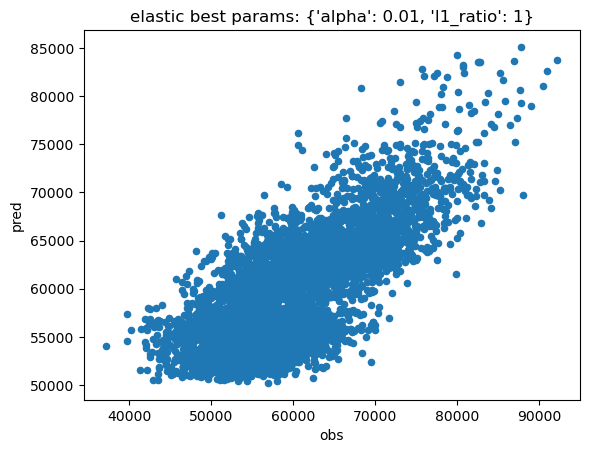

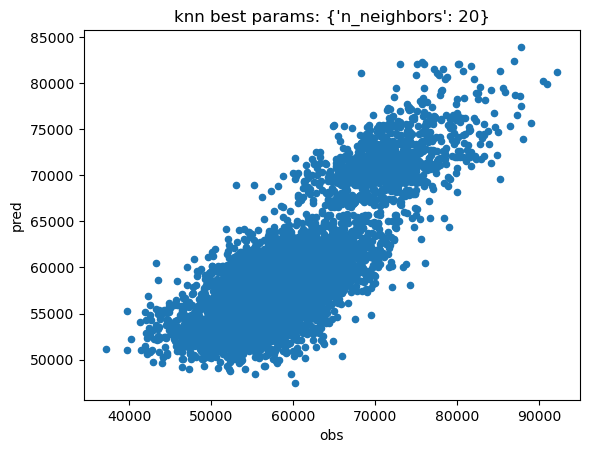

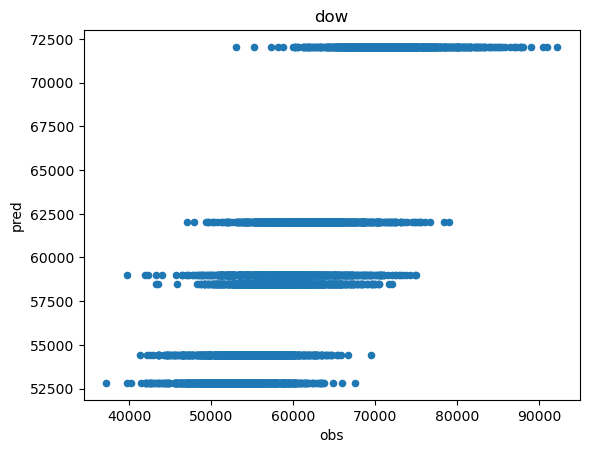

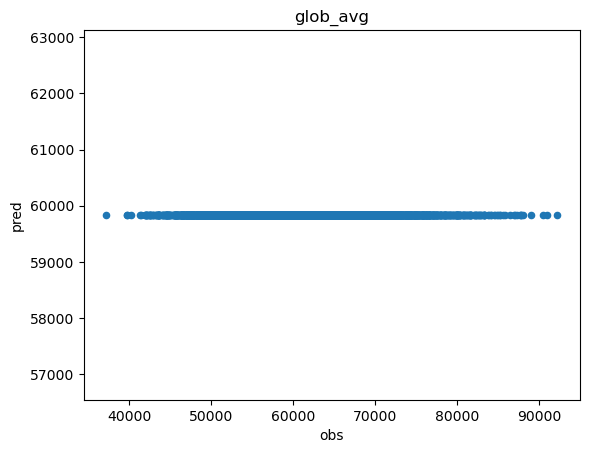

cand   corr  rmse_scaled
0   elastic  0.737        0.676
1       knn  0.818        0.575
2       dow  0.783        0.622
3  glob_avg    NaN        1.000

In [21]:
res = []
predsL = []
for cand, cand_data in dict(**model_cands, **dummy_data).items():
    if not 'results' in cand_data:
        continue
    res.append((cand, cand_data['results']['corr'], cand_data['results']['rmseScaled']))

    predS = pd.Series(cand_data['results']['pred'], index=yTest.index, name='pred')
    resDF = pd.concat([yTest.rename('obs'), predS], axis=1)
    title = cand
    if 'cv' in cand_data['results']:
        title += f" best params: {cand_data['results']['cv'].best_params_}"
    resDF.plot.scatter(x='obs', y='pred', title=title)
    plt.show()

    predsL.append(predS.rename(cand))

pd.DataFrame([(cand, cand_data['results']['corr'], cand_data['results']['rmseScaled'])
              for cand, cand_data in dict(**model_cands, **dummy_data).items() if 'results' in cand_data],
             columns=['cand', 'corr', 'rmse_scaled'])

The following plot shows the weekly number of sales comparing all models under study. There is two versions of the exact same plot: matplotlib and plotly. The latter is more user-friendly allowing zooming and reescaling. However, due to jupyter notebook exportability issues plotly does not always display correctly without re-executing the whole notebook. For this reason, the matplotlib is also shown.
**DISCLAIMER**: As we have previously discussed, this data does not necessarily have a chronological sense in terms of weeks. However, here we plot the sales_per_day grouped per week just so that we can visually analyze discrepancies.

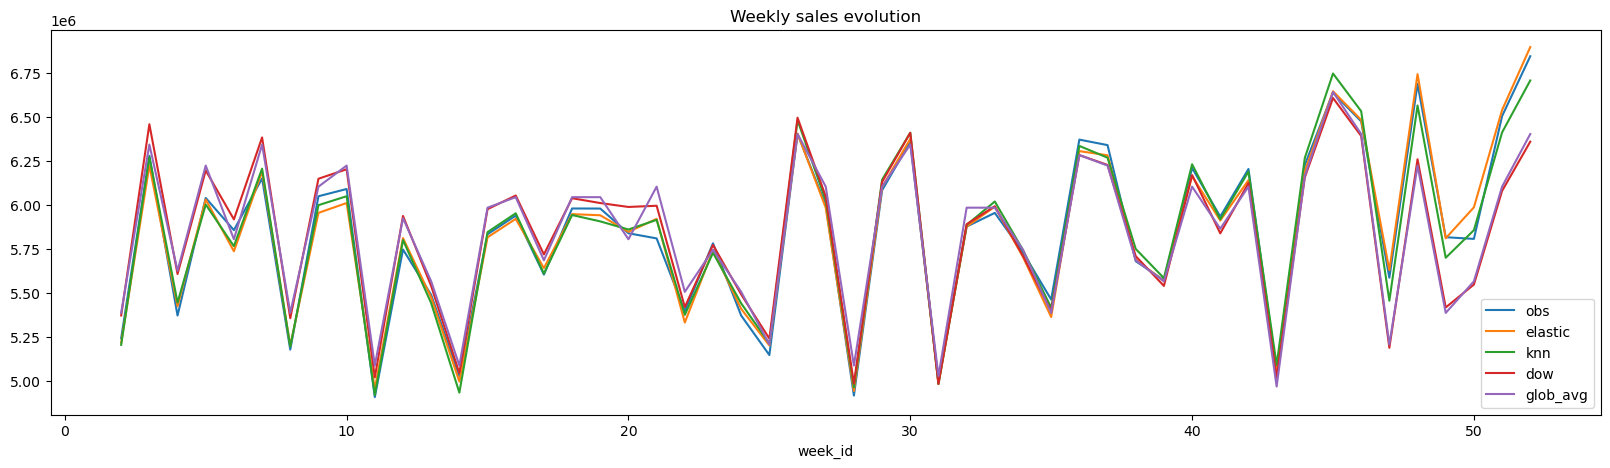

In [22]:
df = pd.concat([data.loc[yTest.index, 'week_id'], yTest.rename('obs'), *predsL], axis=1)
gb_week_df = df.groupby('week_id').sum()

gb_week_df.plot.line(figsize=(20, 5), title='Weekly sales evolution')
plt.show()

fig = px.line(gb_week_df)
fig.show()

As we observed previously the overall performance of the dummy model `dow` is better both in terms of correlation and rmse than the `elastic` model. However, this changes if we focus on the tendency change in the data at the end of the year. The following plot shows the weekly sum of squared differences for each model compared with the observed data. Here we can observe that the weekly performance of `dow`is better than the `elastic` except at the end of the year. During the last weeks of the year both base model are not capable of capturing the change in the tendency of the data.

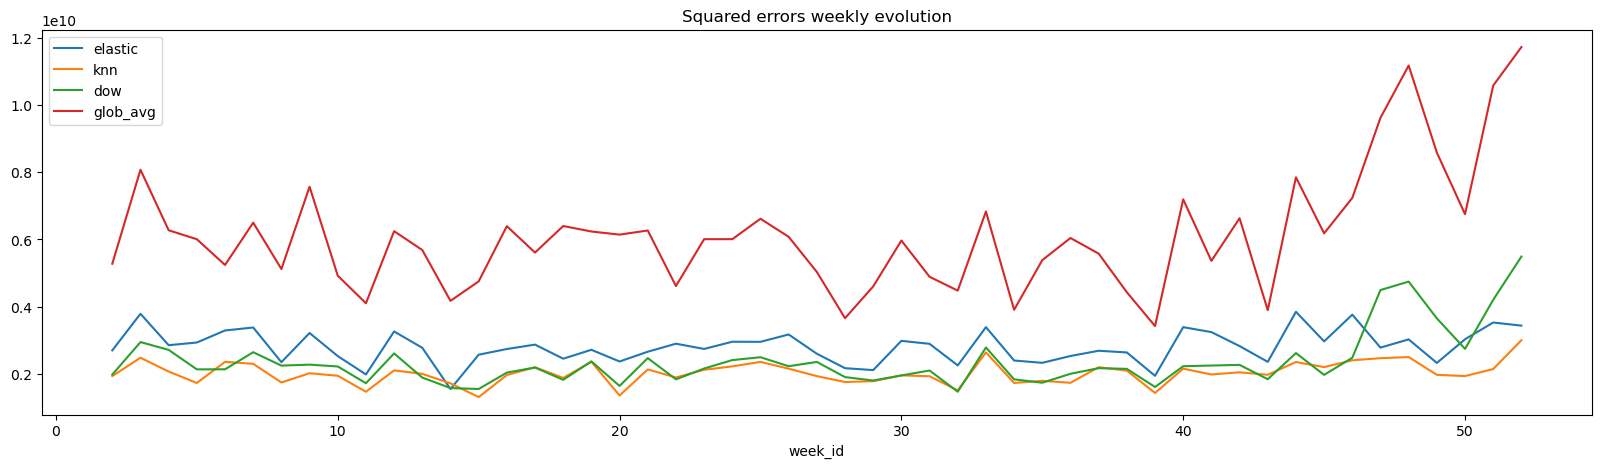

In [23]:
pow_difs_df = df.loc[:, ['elastic', 'knn', 'dow', 'glob_avg']].subtract(df.loc[:, 'obs'], axis=0).pow(2)
pow_difs_df.groupby(df.loc[:, 'week_id']).sum().plot.line(figsize=(20, 5), title='Squared errors weekly evolution')
plt.show()

## Business Problem
What other retail data could be relevant to predict the sales_per_day? Give at least 5 different examples and explain in 2-3 sentences why they could be interesting to add to the model.

- **Year**: The year could provide a better sense of time patterns in the data. As we have all observed in these past years given the pandemic situation seasonality might be altered from time to time. This data could be a game changer providing the possibility of using specific time series forecasting models such LSTMs or ARIMA.
- **Demographic information**: Each store might be related to a certain number of inhabitants within the close by towns or to different cost of living according to the neighbourhood. This information might be of great interest when building a sales prediction model.
- **Revenues objective**: Having the outlet id is great for grouping the data within different outlets as it may change a lot. However, this does not provide much more insights for comparing the outlets. It would be very interesting to have extra information such as the annual revenues expectation per outlet.
- **Extra info about the country**: Similarly to the previous example, it would be also helpful to have extra information about the countries such as GNP or other demographic information.
- **Promotions and sales information**: Special campaigns such as Black Friday or Christmas may have a huge impact on the sales of a store. Although some of this may be captured with an RNN model capable of capturing temporal patterns, it would help to have these campaigns as variables (i.e. avg % of daily discount, most of the days should be 0%).
- **Weather forecast**: People behaviour is very much influenced by the weather. Many would prefer a beach day than a shopping day on a sunny day, and maybe the contrary on a rainny day.
- **More granularity in data**: This is not specifically a new variable. But having a more granular data (i.e. hours, minutes) could provide us a model capable of doing within day predictions. This would be especially useful for the following architecture problem where we want to build a real-time predictor. This could give a prediction given the traffic on an outlet during the morning.

# Architecture

Now pretend you need to build a system which runs the model and should be able to make realtime predictions of the sales per day, everytime new data is generated by the source systems.
You need to design (a) data pipeline(s) which transfers the data from either the sourcesystems or BigQuery to the prediction engine in the format the model/prediction engine can handle it.

There are the following preconditions:

    - There are 3 source systems:
        - System A: System which handles __sales_per_day__ --> API Connector (Real-Time possible)
        - System B: Delivers customers_per_day --> Flat File on SFTP Server once per Day per batch
        - System C: Stores brand, country, currency and outled_id --> BigQuery
        - You want to enable realtime predictions

    - You can use any component you like and would use for that use case. Please add to each logical component for your architecture a respective tool or GCP service. (e.g. for the logical component ETL a tool named Google Dataflow)

Please describe how your architecure would look like with an architecture picture. Describe how the different components will be connected and communicate. Please elaborate why you have choosen a certain logical component + tooling. We expect a moderate level of details within the architecture

# Send it to us
In the end, please send us:
    - The ipython notebook
    - An detailed description of your architecture + an architecture picture (PDF).